In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torchvision.datasets import CIFAR10
from torch.utils.data.dataset import Dataset

In [3]:
import numpy as np
from PIL import Image
import pandas as pd

In [5]:
class CustomDatasetFromImages2(Dataset):
    def __init__(self, csv_path,train=True,transform=None):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file
        self.data_info = pd.read_csv(csv_path)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Third column is for an operation indicator
        #self.operation_arr = np.asarray(self.data_info.iloc[:, 2])
        # Calculate len
        self.data_len = len(self.data_info.index)
        #print(self.image_arr)
        #print(self.label_arr)
        self.train=train
        self.transform = transform
        self.train_labels=np.asarray(self.data_info.iloc[:, 1])
        #self.train_data=np.asarray(self.data_info.iloc[:, 0])
        #self.train_data=transforms(self.image_arr)
        if self.train:
            self.train_data = np.asarray(self.data_info.iloc[:, 0])
            self.train_labels = np.asarray(self.data_info.iloc[:, 1])
            #print(self.train_data)
        else:
            self.test_data = np.asarray(self.data_info.iloc[:, 0])
            self.test_labels = np.asarray(self.data_info.iloc[:, 1])


    def __getitem__(self, index):
        # Get image name from the pandas df
        #single_image_name = self.image_arr[index]
        # Open image
        #img_as_img = Image.open(single_image_name)
        #print(single_image_name)
        #print(img_as_img)
        # Check if there is an operation
        if self.train:

            single_image_name=self.train_data[index]
            single_image_label = self.train_labels[index]
            #print(single_image_name)
        else:

            single_image_name=self.test_data[index]
            single_image_label = self.test_labels[index]

        #some_operation = self.operation_arr[index]
        # If there is an operation
        #if some_operation:
            # Do some operation on image
            # ...
            # ...
           # pass
        # Transform image to tensor
        #img_as_tensor = self.to_tensor(img_as_img)
        #if self.transform is not None:
         #   img_as_tensor = self.transform(img_as_img)
        img_as_img = Image.open(single_image_name)
        #print(img_as_img)
        if self.transform is not None:
            img_as_tensor = self.transform(img_as_img)
        # Get label(class) of the image based on the cropped pandas column
        #single_image_label = self.label_arr[index]
        
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

In [ ]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path,train=False,transform=None):
        """
        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data = pd.read_csv(csv_path)
        self.labels = np.asarray(self.data.iloc[:, 0])
        self.train=train
        self.transform = transform

    def __getitem__(self, index):
        single_image_label = self.labels[index]
        # Read each 784 pixels and reshape the 1D array ([784]) to 2D array ([28,28])
        img_as_np = np.asarray(self.data.iloc[index][1:])
        # Convert image from numpy array to PIL image, mode 'L' is for grayscale
        img_as_img = Image.fromarray(img_as_np)
        img_as_img = img_as_img.convert('L')
        # Transform image to tensor
        if self.transform is not None:
            img_as_tensor = self.transform(img_as_img)
        # Return image and the label
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return len(self.data.index)

In [67]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#train_dataset = CIFAR10('../data/CIFAR10', train=True, download=True,transform=transform)
#test_dataset = CIFAR10('../data/CIFAR10', train=False, download=True,transform=transform)
train_dataset = CustomDatasetFromImages2('C:\\Users\\pupil3000\\Documents\\net\\val_data\\example3.csv', train=True,transform=transform)
test_dataset = CustomDatasetFromImages2('C:\\Users\\pupil3000\\Documents\\net\\val_data\\example3.csv', train=False,transform=transform)
#train_dataset = CustomDatasetFromCSV('C:\\Users\\pupil3000\\Documents\\net\\val_data\\example3.csv', train=True,transform=transform)
#test_dataset = CustomDatasetFromCSV('C:\\Users\\pupil3000\\Documents\\net\\val_data\\example3.csv', train=False,transform=transform)
#n_classes = 186
n_classes = 185

dataset_private_small = CustomDatasetFromImages2('C:\\Users\\pupil3000\\Documents\\net\\val_data\\reference_label_test.csv', train=False,transform=transform)
dataset_private = CustomDatasetFromImages2('C:\\Users\\pupil3000\\Documents\\net\\val_data\\reference_label_test_images.csv', train=False,transform=transform)

In [68]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [69]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [70]:
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

In [98]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(cifar_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 32))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    #print(embeddings)
#     embeddings = PCA(n_components=2).fit_transform(embeddings)
    #embeddings = TSNE(n_components=2, n_iter=300).fit_transform(embeddings)
    return embeddings, labels

In [99]:
import torch.nn as nn
import torch.nn.functional as F

In [100]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 92, 3)
        self.conv4 = nn.Conv2d(92, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*5*5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)

    def forward(self, x):
        output = F.relu(self.conv1(x))
        output = F.relu(self.conv2(output))
        output = self.pool(output)
        output = F.relu(self.conv3(output))
        output = F.relu(self.conv4(output))
        output = self.pool(output)
        output = output.view(-1, self.num_flat_features(output))
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output= self.fc3(output)
        return output
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def get_embedding(self, x):
        return self.forward(x)

In [101]:
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(32, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

In [102]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

private_small_loader = torch.utils.data.DataLoader(dataset_private_small, batch_size=batch_size, shuffle=True, **kwargs)
private_loader = torch.utils.data.DataLoader(dataset_private, batch_size=batch_size, shuffle=False, **kwargs)

In [103]:
# Set up the network and training parameters
# from networks import ClassificationNet
from metrics import AccumulatedAccuracyMetric

In [104]:
embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)

In [105]:
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adamax(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50
log_interval = 50

In [79]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/1860 (0%)]	Loss: 5.149539	Accuracy: 0.0
Epoch: 1/50. Train set: Average loss: 5.1590	Accuracy: 0.10752688172043011
Epoch: 1/50. Validation set: Average loss: 4.9603	Accuracy: 0.5376344086021505
Train: [0/1860 (0%)]	Loss: 4.999852	Accuracy: 0.390625
Epoch: 2/50. Train set: Average loss: 4.9538	Accuracy: 0.43010752688172044
Epoch: 2/50. Validation set: Average loss: 4.7909	Accuracy: 0.5376344086021505
Train: [0/1860 (0%)]	Loss: 4.837250	Accuracy: 0.390625
Epoch: 3/50. Train set: Average loss: 4.7818	Accuracy: 0.5376344086021505
Epoch: 3/50. Validation set: Average loss: 4.7170	Accuracy: 0.5376344086021505
Train: [0/1860 (0%)]	Loss: 4.748160	Accuracy: 0.0
Epoch: 4/50. Train set: Average loss: 4.7293	Accuracy: 0.5376344086021505
Epoch: 4/50. Validation set: Average loss: 4.6842	Accuracy: 0.5376344086021505
Train: [0/1860 (0%)]	Loss: 4.692501	Accuracy: 0.0
Epoch: 5/50. Train set: Average loss: 4.6988	Accuracy: 0.43010752688172044
Epoch: 5/50. Validation set: Average loss: 4.6773	A

KeyboardInterrupt: 

In [106]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
print(train_embeddings_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)

[[-0.00769333  0.02673548  0.03751644 ... -0.01324692  0.00660096
  -0.03070512]
 [-0.00839172  0.02662166  0.03863574 ... -0.01314148  0.00579041
  -0.03077822]
 [-0.00836715  0.02634192  0.03938952 ... -0.01309944  0.00887736
  -0.03111111]
 ...
 [-0.00838186  0.02691178  0.03994634 ... -0.01307513  0.00725489
  -0.03077079]
 [-0.00836015  0.02469375  0.03947242 ... -0.01303293  0.0066596
  -0.03091422]
 [-0.00822163  0.02450401  0.04011488 ... -0.01305561  0.00666532
  -0.03088235]]


In [18]:
train_embeddings_baseline.shape

(50000, 2)

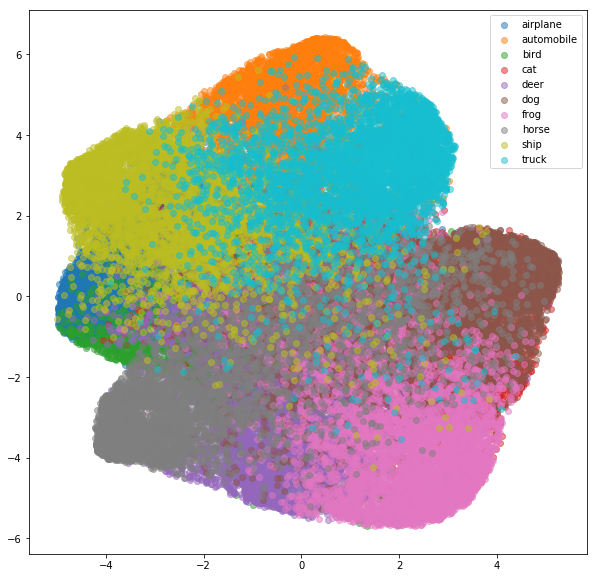

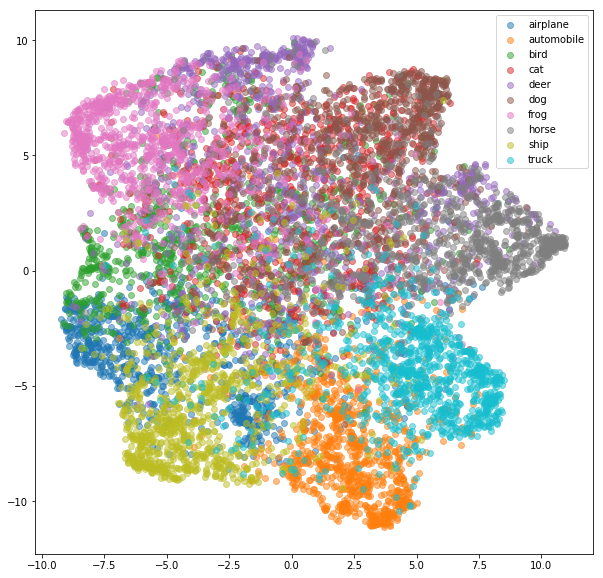

In [19]:
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

In [107]:
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
import cv2


class SiameseCIFAR(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(np.array(self.train_labels))
            self.label_to_indices = {label: np.where(np.array(self.train_labels) == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            self.labels_set = set(np.array(self.test_labels))
            self.label_to_indices = {label: np.where(np.array(self.test_labels) == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i]]),
                               1]
                              for i in range(0, len(self.test_data), 2)]
            
            random_state = np.random.RandomState(29)
            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i]]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index]
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]
            
        img1=cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
        img2=cv2.imread(img2, cv2.IMREAD_GRAYSCALE)
        img1 = Image.fromarray(img1)
        img2 = Image.fromarray(img2)
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return (img1, img2), target

    def __len__(self):
        return len(self.mnist_dataset)

In [108]:
siamese_train_dataset = SiameseCIFAR(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseCIFAR(test_dataset)
batch_size = 128
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [109]:
# Set up the network and training parameters
from networks import SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50
log_interval = 100

In [51]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/1860 (0%)]	Loss: 0.261616
Epoch: 1/50. Train set: Average loss: 0.1595
Epoch: 1/50. Validation set: Average loss: 0.1263
Train: [0/1860 (0%)]	Loss: 0.148471
Epoch: 2/50. Train set: Average loss: 0.1358
Epoch: 2/50. Validation set: Average loss: 0.1370
Train: [0/1860 (0%)]	Loss: 0.127751
Epoch: 3/50. Train set: Average loss: 0.1349
Epoch: 3/50. Validation set: Average loss: 0.1250
Train: [0/1860 (0%)]	Loss: 0.133613
Epoch: 4/50. Train set: Average loss: 0.1309
Epoch: 4/50. Validation set: Average loss: 0.1310
Train: [0/1860 (0%)]	Loss: 0.120585
Epoch: 5/50. Train set: Average loss: 0.1285
Epoch: 5/50. Validation set: Average loss: 0.1348
Train: [0/1860 (0%)]	Loss: 0.130191
Epoch: 6/50. Train set: Average loss: 0.1278
Epoch: 6/50. Validation set: Average loss: 0.1285
Train: [0/1860 (0%)]	Loss: 0.129006
Epoch: 7/50. Train set: Average loss: 0.1217
Epoch: 7/50. Validation set: Average loss: 0.1281
Train: [0/1860 (0%)]	Loss: 0.130665
Epoch: 8/50. Train set: Average loss: 0.1249
Ep

In [54]:
dataset_private_small = CustomDatasetFromImages2('C:\\Users\\pupil3000\\Documents\\net\\val_data\\reference_label_test.csv', train=False,transform=transform)
dataset_private = CustomDatasetFromImages2('C:\\Users\\pupil3000\\Documents\\net\\val_data\\reference_label_test_images.csv', train=False,transform=transform)

In [136]:
#train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
private_embeddings_baseline, private_labels_baseline = extract_embeddings(private_small_loader, model)
print(private_embeddings_baseline)
private2_embeddings_baseline, private2_labels_baseline = extract_embeddings(private_loader, model)
print(private2_embeddings_baseline)
#print(train_labels_baseline)
#val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)

[[-0.03297046 -0.04631876  0.00248631 ... -0.00345947 -0.00015408
  -0.00234461]
 [-0.03438995 -0.04691932  0.00311157 ... -0.004273   -0.00043885
   0.00015044]
 [-0.0334103  -0.04588558  0.00359502 ... -0.00511873 -0.00096513
  -0.00346299]
 ...
 [-0.03296527 -0.04730733  0.00300042 ... -0.00321051  0.00131877
   0.00019182]
 [-0.03219765 -0.04747235  0.00281447 ... -0.00302363  0.00065645
  -0.00048483]
 [-0.03247019 -0.04706148  0.00293938 ... -0.00352167  0.00057903
  -0.00055927]]
[[-3.23879495e-02 -4.64868620e-02  3.37385759e-03 ... -4.70490381e-03
   4.53332439e-04 -5.48455864e-04]
 [-3.02815959e-02 -4.89794090e-02  2.73413397e-03 ... -1.04686059e-03
  -1.25780329e-03 -1.88316777e-03]
 [-3.33803147e-02 -4.61607650e-02  3.80502082e-03 ... -3.43411788e-03
   9.13515687e-05 -1.07467175e-03]
 ...
 [-3.38961110e-02 -4.54685465e-02  4.48692404e-03 ... -3.74606624e-03
   8.77574086e-04 -7.76506960e-04]
 [-3.21271196e-02 -4.83774245e-02  2.64280941e-03 ... -7.80260190e-04
  -8.73468816

In [147]:
private2_embeddings_baseline.shape


(1949, 32)

In [148]:
from scipy.spatial import distance
dst=[]
answ=[]
f=open('C:\\Users\\pupil3000\\Documents\\net\\val_data\\answer.txt','w')

for i in range(private2_embeddings_baseline.shape[0]):
    for j in range(private_embeddings_baseline.shape[0]):
        dst.append(distance.euclidean(private2_embeddings_baseline[i],private_embeddings_baseline[j]))
    mn,ix=min((dst[k],k) for k in range(len(dst)))
    print(mn,"ix ",ix)
    answer=int(private_labels_baseline[ix])
    answ.append(answer)
    f.write(str(answer)+'\n')
    dst.clear()
print(len(answ))

0.004504020443523644 ix  152
0.004965039685786955 ix  150
0.004282125008634875 ix  85
0.007093430318838343 ix  168
0.004088557341590995 ix  175
0.0034400127940215474 ix  42
0.0036000781842473566 ix  32
0.0039535251068706255 ix  8
0.00438660750418785 ix  18
0.0034989236169511778 ix  71
0.00458840692935515 ix  71
0.004411622944025631 ix  176
0.00490518709662821 ix  41
0.004105912787552183 ix  27
0.006064167421074165 ix  94
0.0034495138929744947 ix  71
0.003556729170075843 ix  123
0.004620583714050124 ix  90
0.004374786446559742 ix  59
0.003361847440061477 ix  109
0.003719937097856067 ix  40
0.003972766131874779 ix  173
0.004332841101363447 ix  147
0.004859138795701053 ix  136
0.004278059585569351 ix  41
0.004035635797660426 ix  13
0.004031818045646369 ix  190
0.004319073196054446 ix  63
0.004012209118875308 ix  0
0.0035978047815709495 ix  123
0.004053616581910969 ix  18
0.004325499569875959 ix  169
0.004646481460628538 ix  175
0.004967008152467781 ix  92
0.002416647271000701 ix  52
0.004

0.0041647834391176555 ix  97
0.004309143458243088 ix  127
0.005527079477098906 ix  97
0.004675817992359912 ix  176
0.00409692908364779 ix  16
0.004654539204800417 ix  142
0.004793199104110768 ix  127
0.004263351892093839 ix  30
0.004105763981235768 ix  36
0.005049392069443914 ix  55
0.004101603685197871 ix  143
0.00448271668194881 ix  56
0.004179645805312819 ix  13
0.003621914032173362 ix  12
0.005144544614434676 ix  16
0.003904255662627784 ix  23
0.005030358473422514 ix  142
0.004197566875403072 ix  127
0.0039416505721308805 ix  63
0.0037143415309692615 ix  36
0.003378392640226523 ix  65
0.0 ix  80
0.0038224545605358633 ix  149
0.00480660221598707 ix  184
0.0048900501833684645 ix  176
0.005096182808703238 ix  6
0.0037808956216062437 ix  57
0.00512351946466528 ix  77
0.004618378214002526 ix  54
0.0036347877935031295 ix  32
0.004496227658950624 ix  55
0.003443308642853472 ix  0
0.003919800814219285 ix  36
0.0038921029728304257 ix  132
0.004642443810401132 ix  113
0.0037776610009060793 i

0.004690997034752357 ix  71
0.004268094140533862 ix  120
0.003256381126011878 ix  0
0.004231567847027848 ix  154
0.0037487323693355654 ix  32
0.0038957752625693757 ix  118
0.003437584875055325 ix  0
0.0038179425232530055 ix  53
0.0036319474412861864 ix  109
0.0050064635782402075 ix  66
0.0043019748631098025 ix  130
0.004018843837416772 ix  79
0.002877790836892346 ix  191
0.0045018845830138605 ix  150
0.003994020300668828 ix  154
0.0049101162332179545 ix  106
0.005254461102232048 ix  176
0.004311007505111569 ix  148
0.004264256351550908 ix  8
0.003767324977641584 ix  124
0.0037263066266875005 ix  90
0.005641143590392352 ix  82
0.0047624345071638 ix  44
0.007340681368759602 ix  189
0.005945888804574417 ix  106
0.004555760632469796 ix  22
0.00622239109081576 ix  38
0.005633409963850438 ix  35
0.0031872029892981496 ix  120
0.005423126211698258 ix  38
0.004973708338637622 ix  8
0.0043831173729544926 ix  55
0.004336261517172865 ix  86
0.005152204682554172 ix  58
0.0037422602938350204 ix  31


0.004222185995654219 ix  43
0.0028101662674691157 ix  148
0.00473136684060105 ix  193
0.004428696267817936 ix  0
0.003917827542247549 ix  51
0.004067053585887175 ix  21
0.004148017667810983 ix  120
0.003970304559438498 ix  85
0.003691816557503608 ix  148
0.006308175726210773 ix  28
0.003964035983568116 ix  148
0.004099717299614095 ix  191
0.004799628213812435 ix  116
0.004454422604768756 ix  67
0.004216295965195127 ix  36
0.0032730595910524874 ix  148
0.004604830355374027 ix  36
0.005068859738223052 ix  129
0.004607435816466979 ix  172
0.0036536080382471334 ix  32
0.00356145948966692 ix  142
0.004522043300404519 ix  21
0.004891660724347173 ix  55
0.0038269394863866407 ix  184
0.004767511212994513 ix  59
0.004408705639086658 ix  130
0.0046081889464142265 ix  164
0.0045282743887783625 ix  42
0.0036157726795430075 ix  0
0.004256982328725045 ix  181
0.004685561389996573 ix  133
0.004396123138724782 ix  193
0.005523862199119824 ix  133
0.0035082773702911556 ix  191
0.004743687547424958 ix  

0.0033258294368473332 ix  156
0.003357148320755044 ix  63
0.003424763425733551 ix  116
0.0032276785403818624 ix  148
0.005270623925765389 ix  14
0.004939216920501364 ix  14
0.006030494402837585 ix  182
0.0034943869897970975 ix  71
0.005377421149409183 ix  165
0.005981093974844216 ix  159
0.004511335340273138 ix  176
0.004566003386351246 ix  152
0.004994580877333532 ix  114
0.0036152561256746784 ix  36
0.003985815837810813 ix  47
0.0038823312531101792 ix  30
0.0032812788776451995 ix  173
0.0041806573587367495 ix  51
0.00481776617585074 ix  181
0.0031326553375748173 ix  32
0.003167448178172359 ix  0
0.00432126638091191 ix  2
0.0035766212872825557 ix  97
0.003432817413088891 ix  119
0.004095622780106353 ix  51
0.005532608827970863 ix  142
0.00667557160388823 ix  118
0.0036439347649435015 ix  175
0.0044570292930499866 ix  30
0.006089299886915185 ix  150
0.0036393869826814545 ix  10
0.0049313490855592895 ix  0
0.0034806307916246822 ix  74
0.0028452469533320262 ix  120
0.004250729225433619 i

0.004018415817119129 ix  184
0.004464927609268026 ix  161
0.004252840603246935 ix  128
0.0038889908046986117 ix  30
0.00454520310394138 ix  154
0.0041842802217348695 ix  15
0.0030154418400338274 ix  32
0.005307737492059776 ix  181
0.004575217183765792 ix  38
0.00365472558880388 ix  109
0.005195479576470057 ix  4
0.00516641399958166 ix  130
0.004684391456061826 ix  85
0.004342103262445632 ix  143
0.003778998185867257 ix  31
0.004332395123108841 ix  153
0.004352459219479144 ix  98
0.003912098573526415 ix  85
0.004148068803239249 ix  156
0.003514438342076535 ix  52
0.004396864727055497 ix  52
0.0032796357488712644 ix  175
0.003070200885138318 ix  0
0.004033146335034131 ix  147
0.004491938220289973 ix  109
0.004383592840849156 ix  130
0.005016118793368107 ix  177
0.005420225300678143 ix  113
0.004728717920110482 ix  60
0.0035941905941181355 ix  55
0.004312169124750301 ix  92
0.004012314256644507 ix  129
0.0028632981319927247 ix  148
0.004488880148540342 ix  2
0.004103451648969052 ix  59
0.

## plot_embeddings(train_embeddings_baseline, train_labels_baseline)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

In [82]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR10('../data/CIFAR10', train=True, download=True,
                             transform=transform)
test_dataset = CIFAR10('../data/CIFAR10', train=False, download=True,
                            transform=transform)
n_classes = 10

Files already downloaded and verified
Files already downloaded and verified


In [46]:
class TripletCIFAR(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(np.array(self.train_labels))
            self.label_to_indices = {label: np.where(self.train_labels == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            # generate fixed triplets for testing
            self.labels_set = set(np.array(self.test_labels))
            self.label_to_indices = {label: np.where(self.test_labels == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)
            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i]]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i]]))
                                                 )
                                             ])
                         ] for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index]
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]
        img1=cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
        img2=cv2.imread(img2, cv2.IMREAD_GRAYSCALE)
        img3=cv2.imread(img3, cv2.IMREAD_GRAYSCALE)
        img1 = Image.fromarray(img1)
        img2 = Image.fromarray(img2)
        img3 = Image.fromarray(img3)
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3), []

    def __len__(self):
        return len(self.mnist_dataset)

In [47]:
triplet_train_dataset = TripletCIFAR(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletCIFAR(test_dataset)

In [48]:
batch_size = 128
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [49]:
# Set up the network and training parameters
from networks import TripletNet
from losses import TripletLoss

In [52]:
margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [53]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/1860 (0%)]	Loss: 0.999999
Epoch: 1/40. Train set: Average loss: 0.9839
Epoch: 1/40. Validation set: Average loss: 0.9724
Train: [0/1860 (0%)]	Loss: 0.993932
Epoch: 2/40. Train set: Average loss: 0.9769
Epoch: 2/40. Validation set: Average loss: 0.9528
Train: [0/1860 (0%)]	Loss: 0.976117
Epoch: 3/40. Train set: Average loss: 0.9422
Epoch: 3/40. Validation set: Average loss: 0.8617
Train: [0/1860 (0%)]	Loss: 0.921534
Epoch: 4/40. Train set: Average loss: 0.9234
Epoch: 4/40. Validation set: Average loss: 0.8839
Train: [0/1860 (0%)]	Loss: 0.829911
Epoch: 5/40. Train set: Average loss: 0.9302
Epoch: 5/40. Validation set: Average loss: 0.9199
Train: [0/1860 (0%)]	Loss: 0.970794
Epoch: 6/40. Train set: Average loss: 0.9363
Epoch: 6/40. Validation set: Average loss: 0.8736
Train: [0/1860 (0%)]	Loss: 0.909890
Epoch: 7/40. Train set: Average loss: 0.9182
Epoch: 7/40. Validation set: Average loss: 0.8718
Train: [0/1860 (0%)]	Loss: 0.917570
Epoch: 8/40. Train set: Average loss: 0.9022
Ep

In [93]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)

In [94]:
train_embeddings_baseline.shape

(50000, 2)

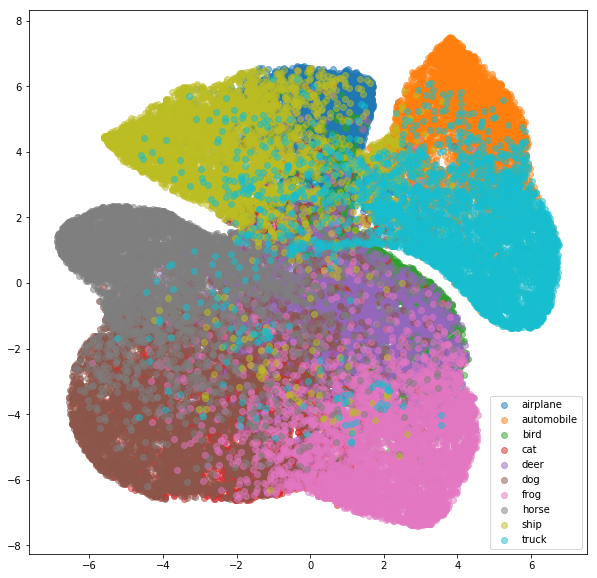

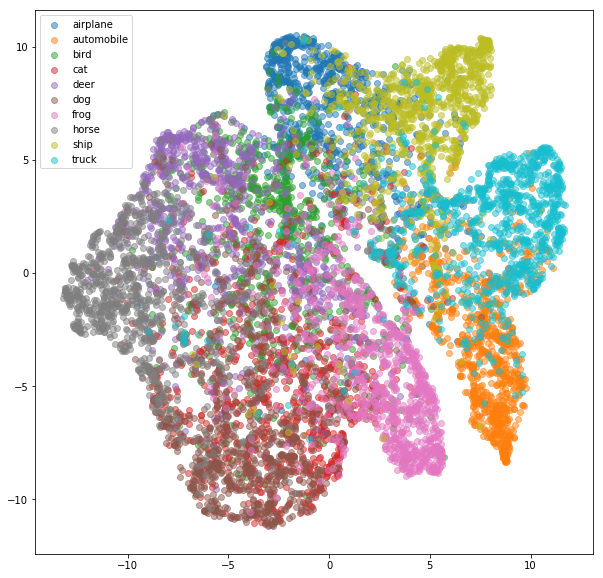

In [95]:
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)